# Assignment 15: Model Test Accuracy Calculations

Dataset is splitted into 70:30 for training and test samples. All models were trained on same set of training samples. None of the model have ever seen test samples while training as it is kept seperate from the dataset as below:
- Train Samples: train_filelist_400k.txt
- Test Samples: test_filelist_400k.txt

Test accuracy is calculated for following below models. 

Model trained on short dataset, 15272 training samples for different loss fucntions:
- Model-1: DMNet_CNN.py, Loss: BCEWithLogitsLoss
- Model-2: DMNet_CNN.py, Loss: SmoothL1Loss
- Model-3: DMNet_CNN.py, Loss: MSELoss
- Model-4: DMNet_CNN.py, Loss: SSIMLoss

Model trained on entire dataset(400K): 280K used for training samples and rest of 120K samples kept untouch for testing:
- Model-5: DMNet_CNN_V1.py, Loss: BCEWithLogitsLoss
- Model-6: DMNet_CNN_V1.py, Loss: BCEWithLogitsLoss


*How Accuracy is calculated?*
- Ground truth and predicted images are compared using Structural Similarity Index Mesaure Algorithm and threshold is defined for correct and incorrect prediction.
- As our model is to predict mask and depth map and it mostly dealt with edges and object boundaries, and hence SSIM found to be one of the useful algoritm as it find similarity between images using structural patterns.
- In SSIM, index close to 1 mean two images are same while close to 0 mean having dissimilarity.
- For Mask: SSIM threshold is kept as 0.90 and any prediction above it are cosnidered as good prediction. However, setting of threshold is quite subjective and user can play with different threshold as per their model efficieny requirement and resource trade-off
- For Depth: SSIM threshold is kept as 0.50 and any prediction above it are considered as good prediction. As Ground truth for Depth mask were not so accurate with respective to fg_bg images and hence for current situation, Depth Map prediction will not yeild good result. Again, we can build high capacity model for Depth prediction and threshold can be made aggresive

In [0]:
# mount gdrive
from google.colab import drive
drive.mount('/content/gdrive') 

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# check for desired GPU allocation
import torch
prop = torch.cuda.get_device_properties(0)
gpu = 'P100' #'Tesla P100-PCIE-16GB'
if prop.name.find(gpu) != -1:
   print("Welcome: ", prop.name)
else:
  print("Got GPU: ", prop.name)
  print("I need higher GPU, so restarting")
  exit()

Welcome:  Tesla P100-PCIE-16GB


In [0]:
# switch to root working directory
import os
os.chdir('/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier/')
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier


## Load standard and custom python packages

In [0]:
#Load the TensorBoard extension
%load_ext tensorboard

In [0]:
import pkgutil
if pkgutil.find_loader("kornia") is None:
  !pip install kornia

In [0]:
import os
print(os.getcwd())

/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_qualifier


In [0]:
# Load standard packages
from __future__ import print_function
import torch
from torch.utils.tensorboard import SummaryWriter

from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#plt.ion()   # interactive mode

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [0]:
# load custom python packages
import utils.common_utils as cutils           # common utililies fxn
import utils.plot_utils as plot_utils         # utilities for ploting images, model history, misclassified images etc

from utils.DepthMapDataset import DepthMapDatasetFolder, DepthMapDatasetFxn

In [0]:
# to autoreload all the custom files when modified
import autoreload
%load_ext autoreload
%autoreload

# Check GPU avaiability
use cuda and get device with GPU

In [0]:
# check GPU availability and use cuda to get GPU device
cuda, device = cutils.get_device()
print('PyTorch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

CUDA Available? True
Device:  cuda:0
PyTorch 1.5.0+cu101 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Basis configurations

In [0]:
'''
initilize directory location for log and tensor board
'''

SOLUTION_LOG_DIR = "logs/logs_accuracy"     # root directoy for all the log of this notebook
Path(f'./{SOLUTION_LOG_DIR}').mkdir(exist_ok=True)

TENSOR_BOARD_LOG_DIR = f'./{SOLUTION_LOG_DIR}/tb_logs' #root directory to log tensor board results

PLOT_DIR = Path(f'./{SOLUTION_LOG_DIR}/doc_images')
PLOT_DIR.mkdir(exist_ok=True)

In [0]:
config_params = dict(
    seed=1,
    batch_size=32,
    num_workers=6
)

m_threshold=0.90   # SSIM threshold for Mask Prediction correctness 
d_threshold=0.50   # SSIM threshold for Depth Prediction correctness- little lineant here
save_freq=1000     # log frequency

# For reproducibility
torch.manual_seed(config_params["seed"])

if cuda:
    torch.cuda.manual_seed(config_params["seed"])

In [0]:
tb_writer = SummaryWriter(f'{TENSOR_BOARD_LOG_DIR}/my_board')

In [0]:
# initialize dataset locations

#zip file location
src_dataset_dir = "/content/gdrive/My Drive/TSAI/EVA_Phase1/session14_15/s15_assignment_A/dataset"
bg_zipname = f'{src_dataset_dir}/bg_images.zip'  
fg_bg_zipname = f'{src_dataset_dir}/fg_bg_images.zip'  
fg_bg_mask_zipname = f'{src_dataset_dir}/fg_bg_mask_images_c1.zip'  
fg_bg_depth_zipname = f'{src_dataset_dir}/fg_bg_depth_images.zip'  

#unzip locations: note path shall be colab internal memory location not on mounted drive.
root_dataset = '/content/eva15_dataset'
bg_dir = f'{root_dataset}/bg_images'                    # background images location
fg_bg_dir = f'{root_dataset}/fg_bg_images'              # forground-background overlay images location
fg_bg_mask_dir = f'{root_dataset}/fg_bg_mask_images_c1'    # forground-background overlay mask images location
fg_bg_depth_dir = f'{root_dataset}/fg_bg_depth_images'  # forground-background depth map images location

ds_folder_dict = {"bg": bg_dir,
                    "fgbg": fg_bg_dir,
                    "mask": fg_bg_mask_dir,
                    "depth": fg_bg_depth_dir}

In [0]:
%%time

import zipfile

def extract_dataset(fn, dest):
    with open(fn, 'rb') as f:
      zf = zipfile.ZipFile(f)
      zf.extractall(dest)

if not Path(root_dataset).exists():
  Path(root_dataset).mkdir(exist_ok=True)

if not Path(bg_dir).exists():
  print("Extracting bg_images ...")
  extract_dataset(fn=bg_zipname, dest=bg_dir)

if not Path(fg_bg_dir).exists():
  print("Extracting fg_bg_images ...")
  extract_dataset(fn=fg_bg_zipname, dest=fg_bg_dir)

if not Path(fg_bg_mask_dir).exists():
  print("Extracting fg_bg_mask_images ...")
  extract_dataset(fn=fg_bg_mask_zipname, dest=fg_bg_mask_dir)

if not Path(fg_bg_depth_dir).exists():
  print("Extracting fg_bg_depth_images ...")
  extract_dataset(fn=fg_bg_depth_zipname, dest=fg_bg_depth_dir)

# display the content size
print("bg images: ", len(os.listdir(bg_dir)))
print("fg_bg images: ", len(os.listdir(fg_bg_dir)))
print("fg_bg_mask images: ", len(os.listdir(fg_bg_mask_dir)))
print("fg_bg_depth images: ", len(os.listdir(fg_bg_depth_dir)))

bg images:  100
fg_bg images:  400000
fg_bg_mask images:  400000
fg_bg_depth images:  400000
CPU times: user 260 ms, sys: 383 ms, total: 643 ms
Wall time: 735 ms


In [0]:
'''
# if image folder does not exist then unzip all the dataset
if not Path(root_dataset).exists():
  print(" Directory does not exist.. unzip all dataset")
  Path(root_dataset).mkdir(exist_ok=True)
  print("unzipping bg_images ...")
  !unzip -q '{src_dataset_dir}/bg_images.zip' -d '{root_dataset}/bg_images'
  print("unzipping fg_bg_images ...")
  !unzip -q '{src_dataset_dir}/fg_bg_images.zip' -d '{root_dataset}/fg_bg_images'
  print("unzipping fg_bg_mask_images ...")
  !unzip -q '{src_dataset_dir}/fg_bg_mask_images_c1.zip' -d '{root_dataset}/fg_bg_mask_images'
  print("unzipping fg_bg_depth_images ...")
  !unzip -q '{src_dataset_dir}/fg_bg_depth_images.zip' -d '{root_dataset}/fg_bg_depth_images'
  print("unzipping completed \n")

# display the content size
print("bg images: ", len(os.listdir(bg_dir)))
print("fg_bg images: ", len(os.listdir(fg_bg_dir)))
print("fg_bg_mask images: ", len(os.listdir(fg_bg_mask_dir)))
print("fg_bg_depth images: ", len(os.listdir(fg_bg_depth_dir)))
'''

'\n# if image folder does not exist then unzip all the dataset\nif not Path(root_dataset).exists():\n  print(" Directory does not exist.. unzip all dataset")\n  Path(root_dataset).mkdir(exist_ok=True)\n  print("unzipping bg_images ...")\n  !unzip -q \'{src_dataset_dir}/bg_images.zip\' -d \'{root_dataset}/bg_images\'\n  print("unzipping fg_bg_images ...")\n  !unzip -q \'{src_dataset_dir}/fg_bg_images.zip\' -d \'{root_dataset}/fg_bg_images\'\n  print("unzipping fg_bg_mask_images ...")\n  !unzip -q \'{src_dataset_dir}/fg_bg_mask_images_c1.zip\' -d \'{root_dataset}/fg_bg_mask_images\'\n  print("unzipping fg_bg_depth_images ...")\n  !unzip -q \'{src_dataset_dir}/fg_bg_depth_images.zip\' -d \'{root_dataset}/fg_bg_depth_images\'\n  print("unzipping completed \n")\n\n# display the content size\nprint("bg images: ", len(os.listdir(bg_dir)))\nprint("fg_bg images: ", len(os.listdir(fg_bg_dir)))\nprint("fg_bg_mask images: ", len(os.listdir(fg_bg_mask_dir)))\nprint("fg_bg_depth images: ", len(os.li

In [0]:
# This for running code in local machine 
'''
src_dataset_dir = 'D:/my_learning/TSAI/EVA4/assignments/Session14_15/dataset_final'
root_dataset = 'D:/my_learning/TSAI/EVA4/assignments/Session14_15/dataset_final'
bg_dir = f'{root_dataset}/bg_images'                    # background images location
fg_bg_dir = f'{root_dataset}/fg_bg_images'              # forground-background overlay images location
fg_bg_mask_dir = f'{root_dataset}/fg_bg_mask_images_c1'    # forground-background overlay mask images location
fg_bg_depth_dir = f'{root_dataset}/fg_bg_depth_images'  # forground-background depth map images location

ds_folder_dict = {"bg": bg_dir,
                    "fgbg": fg_bg_dir,
                    "mask": fg_bg_mask_dir,
                    "depth": fg_bg_depth_dir}
'''

'\nsrc_dataset_dir = \'D:/my_learning/TSAI/EVA4/assignments/Session14_15/dataset_final\'\nroot_dataset = \'D:/my_learning/TSAI/EVA4/assignments/Session14_15/dataset_final\'\nbg_dir = f\'{root_dataset}/bg_images\'                    # background images location\nfg_bg_dir = f\'{root_dataset}/fg_bg_images\'              # forground-background overlay images location\nfg_bg_mask_dir = f\'{root_dataset}/fg_bg_mask_images_c1\'    # forground-background overlay mask images location\nfg_bg_depth_dir = f\'{root_dataset}/fg_bg_depth_images\'  # forground-background depth map images location\n\nds_folder_dict = {"bg": bg_dir,\n                    "fgbg": fg_bg_dir,\n                    "mask": fg_bg_mask_dir,\n                    "depth": fg_bg_depth_dir}\n'

In [0]:
# more about dataset
import pandas as pd
df_ds = pd.read_csv(f'{src_dataset_dir}/dataset_summary.csv')
df_ds

,Unnamed: 0,Kinds,Total Images,Total Size (MB),Image Dimension,Channels,Means,Stds
0,0,bg,100,1.888,"(192, 192)",3,[142.3604 129.986 115.9921],[65.6258 64.9718 65.5989]
1,1,fg,100,0.456,size of an object in image,3,NaN,NaN
2,2,fg_mask,100,0.289,same as fg image,1,NaN,NaN
3,3,fg_bg,400000,7941.210,"(192, 192)",3,[142.8615 130.0039 117.2206],[66.4145 65.5184 66.0169]
4,4,fg_bg_mask,400000,846.108,"(192, 192)",1,[23.2702],[72.9364]
5,5,fg_bg_depth,400000,3237.788,"(240, 240)",1,[147.4633],[72.0034]


In [0]:
# dataset means and stds
bg_means, bg_stds = np.round(np.array([142.3604, 129.986, 115.9921])/255., 3) , np.round(np.array([65.6258, 64.9718, 65.5989])/255., 3)
fg_bg_means, fg_bg_stds =  np.round(np.array([142.8615, 130.0039, 117.2206])/255., 3) ,	 np.round(np.array([66.4145, 65.5184, 66.0169])/255., 3)
mask_means, mask_stds =  np.round(np.array([23.2702])/255., 3) ,  np.round(np.array([72.9364])/255., 3)
depth_means, depth_stds =  np.round(np.array([147.4633])/255., 3) ,  np.round(np.array([72.0034])/255., 3)

ds_means_stds = {
    "bg_means": bg_means,
    "bg_stds": bg_stds,
    "fg_bg_means": fg_bg_means,
    "fg_bg_stds": fg_bg_stds,
    "mask_means": mask_means,
    "mask_stds": mask_stds,
    "depth_means": depth_means,
    "depth_stds": depth_stds,
}

ds_means_stds

{'bg_means': array([0.558, 0.51 , 0.455]),
 'bg_stds': array([0.257, 0.255, 0.257]),
 'depth_means': array([0.578]),
 'depth_stds': array([0.282]),
 'fg_bg_means': array([0.56, 0.51, 0.46]),
 'fg_bg_stds': array([0.26 , 0.257, 0.259]),
 'mask_means': array([0.091]),
 'mask_stds': array([0.286])}

In [0]:
#bg_means, bg_stds = np.round(np.array([142.3604, 129.986, 115.9921]), 3) , np.round(np.array([65.6258, 64.9718, 65.5989]), 3)
#fg_bg_means, fg_bg_stds =  np.round(np.array([142.8615, 130.0039, 117.2206]), 3) ,	 np.round(np.array([66.4145, 65.5184, 66.0169]), 3)
#mask_means, mask_stds =  np.round(np.array([23.2702]), 3) ,  np.round(np.array([72.9364]), 3)
#depth_means, depth_stds =  np.round(np.array([147.4633]), 3) ,  np.round(np.array([72.0034]), 3)

In [0]:
from torchvision.transforms import transforms

# keep all image size same for simplicity
img_size = (192,192)

# test transforms
test_bg_transform = transforms.Compose([
                              #transforms.Resize(size=img_size),
                              transforms.ToTensor(),
                              transforms.Normalize(bg_means, bg_stds)
                              ])

test_fgbg_transform = transforms.Compose([
                              #transforms.Resize(size=img_size),
                              transforms.ToTensor(),
                              transforms.Normalize(fg_bg_means, fg_bg_stds)
                              ])

# transform for mask and depth (for both train and test dataset)
gt_transform=transforms.Compose([
                              transforms.Resize(size=img_size),
                              transforms.ToTensor()
                              ])


In [0]:
test_filename = "test_filelist_400k.txt"
print(f"Reading test image names from {test_filename}")
test_files = DepthMapDatasetFxn().read_img_filenames(test_filename)

Reading test image names from test_filelist_400k.txt


In [0]:
#test_files = test_files[:500]
#save_freq = 10

In [0]:
test_dataset = DepthMapDatasetFolder(ds_folder_dict, im_files=test_files, 
                               bg_transform = test_bg_transform, 
                               fgbg_transform = test_fgbg_transform, 
                               mask_transform = gt_transform,
                               depth_transform = gt_transform)
print(f'test count: {len(test_dataset)}')

test count: 120000


In [0]:
# dataset dimensions
[(k, v.shape) for k, v in test_dataset[0].items()]

[('bg', torch.Size([3, 192, 192])),
 ('fgbg', torch.Size([3, 192, 192])),
 ('mask', torch.Size([1, 192, 192])),
 ('depth', torch.Size([1, 192, 192]))]

In [0]:
from torch.utils.data import DataLoader

dataloader_args = dict(shuffle=False, batch_size=config_params["batch_size"], num_workers=config_params["num_workers"], pin_memory=True) if cuda else dict(shuffle=True, batch_size=8)
test_loader = DataLoader(test_dataset, **dataloader_args)

In [0]:
# common utility fucntion

'''
Loss class to combine loss of mask and depth
Analysis: 
1. comparitively loss for Depth is higher than that of Mask and it is obvious as depth have much more objects and its gradient to captures.
2. total loss is calculated as sum of square root losses. square root have a property that for values less than 1, lower values yield higher result compare to higher values
doing so the loss ratio get reduce. even though total loss increases but loss ratio is reduces
'''
class CustomLoss_SqrtSum():
  def __init__(self, criterion):
      self.criterion = criterion

  def __call__(self, output_m, target_m, output_d, target_d):
      loss_m = self.criterion(output_m, target_m)
      loss_d = self.criterion(output_d, target_d)
      loss = torch.sqrt(loss_m) + torch.sqrt(loss_d)
      return loss, loss_m, loss_d

class CustomLoss_WeightedSum():
  def __init__(self, criterion, m_wt=1, d_wt=1):
      self.criterion = criterion
      self.m_wt = m_wt
      self.d_wt = d_wt

  def __call__(self, output_m, target_m, output_d, target_d):
      loss_m = self.criterion(output_m, target_m)
      loss_d = self.criterion(output_d, target_d)
      loss = self.m_wt*loss_m + self.d_wt*loss_d
      return loss, loss_m, loss_d

In [0]:
def load_my_model(model, device, modelpath):
    checkpoint = torch.load(modelpath, map_location={'cuda:0': 'cpu'})
    model.load_state_dict(checkpoint['state_dict'])
    model =  model.to(device)
    return model

In [0]:
from skimage.measure import compare_ssim
import imutils
import cv2
import utils.plot_utils as plot_utils
from tqdm import tqdm

def save_plot_results(output, data, ds_means_stds, idx, path_dir):
    fileExt = "png"
    plot_utils.visualize_data(output[0], figsize=(10,10), filename=path_dir/f'b{idx}_mask_pred.{fileExt}', show=True, nrow=4)
    plot_utils.visualize_data(output[1], figsize=(10,10), filename=path_dir/f'b{idx}_depth_pred.{fileExt}', show=True, nrow=4)
    plot_utils.visualize_data_norm(data["bg"], ds_means_stds['bg_means'], ds_means_stds['bg_stds'], figsize=(10,10), filename=path_dir/f'b{idx}_bg.{fileExt}', show=False, nrow=4)
    plot_utils.visualize_data_norm(data["fgbg"], ds_means_stds['fg_bg_means'], ds_means_stds['fg_bg_stds'], figsize=(10,10), filename=path_dir/f'b{idx}_fgbg.{fileExt}', show=False, nrow=4)
    plot_utils.visualize_data(data["mask"], figsize=(10,10), filename=path_dir/f'b{idx}_mask_gt.{fileExt}', show=False, nrow=4)
    plot_utils.visualize_data(data["depth"], figsize=(10,10), filename=path_dir/f'b{idx}_depth_gt.{fileExt}', show=False, nrow=4)

def compare_image_ssim(img1, img2):
    '''
    compute the Structural Similarity Index (SSIM) between the two
    images, ensuring that the difference image is returned
    '''
    (score, diff) = compare_ssim(img1, img2, full=True)
    diff = (diff * 255).astype("uint8")
    #print("SSIM: {}".format(score))
    return score, diff

def plot_save_acc(img1, img2, diff, tag, show=False, filename=None):
    # threshold the difference image, followed by finding contours to
    # obtain the regions of the two input images that differ
    thresh = cv2.threshold(diff, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    gt = img1.copy()
    
    # loop over the contours
    for c in cnts:
        # compute the bounding box of the contour and then draw the
        # bounding box on both input images to represent where the two
        # images differ
        (x, y, w, h) = cv2.boundingRect(c)
        cv2.rectangle(img1, (x, y), (x + w, y + h), (0, 0, 255), 2)
        #cv2.rectangle(img2, (x, y), (x + w, y + h), (0, 0, 255), 2)

    # show the output images
    fig, axs = plt.subplots(1,5,figsize=(15,5))
    
    label = f'{tag}-GT'
    axs[0].imshow(gt, cmap='gray')
    axs[0].set_title(label)

    label = f'{tag}-PRED'
    axs[1].imshow(img2, cmap='gray')
    axs[1].set_title(label)
    
    label = f'{tag}-GT-DIFF-REGION'
    axs[2].imshow(img1, cmap='gray')
    axs[2].set_title(label)

    label = f'{tag}-DIFF'
    axs[3].imshow(diff, cmap='gray')
    axs[3].set_title(label)

    label = f'{tag}-THRESHOLD'
    axs[4].imshow(thresh, cmap='gray')
    axs[4].set_title(label)

    if filename:
      plt.savefig(filename)   
    if show:   
      plt.show()
    
    plt.clf()
    
def standardize_imge(img):
    img[img < 0] = 0 # filter negative values
    #im = (img - np.min(img)) / (np.max(img) - np.min(img))
    im = (img - np.min(img)) / np.max(img) 
    return im

def get_accuracy(output, data, bidx, path_dir, save_freq=1000):
    fileExt = "png"
    try:
        m_pred = output[0].detach().cpu()
        d_pred = output[1].detach().cpu()
        m_gt = data["mask"].detach().cpu()
        d_gt = data["depth"].detach().cpu()
    except:
        print('get_accuracy: error..')
        pass
        
    m_score_list = []
    d_score_list = []
    
    for idx in np.arange(len(m_pred)):
        img1 = m_gt[idx][0,:,:].numpy()
        img2 = m_pred[idx][0,:,:].numpy()
        img2 = standardize_imge(img2)
     
        # compare mask prediction and Ground Truth
        score, diff = compare_image_ssim(img1, img2)
        m_score_list.append(score)
        if((bidx==1) or (bidx%save_freq==0)) and (idx==0):
            print(f'\nMASK Similarity Index: {score}')
            plot_save_acc(img1, img2, diff, tag='MASK', show=True, filename=path_dir/f'acc_b{bidx}_{idx+1}_mask.{fileExt}')
        
        # compare mask prediction and Ground Truth
        img1 = d_gt[idx][0,:,:].numpy()
        img2 = d_pred[idx][0,:,:].numpy()      
        img2 = standardize_imge(img2)
        
        # compare mask prediction and Ground Truth
        score, diff = compare_image_ssim(img1, img2)
        d_score_list.append(score)
        if((bidx==1) or (bidx%save_freq==0)) and (idx==0):
            print(f'DEPTH Similarity Index: {score}')
            plot_save_acc(img1, img2, diff, tag='DEPTH', show=True, filename=path_dir/f'acc_b{bidx}_{idx+1}_depth.{fileExt}')

    return m_score_list, d_score_list

def run_test_data(model, device, testloader, ds_means_stds, path_dir, m_threshold, d_threshold, save_freq=1000):
    m_correct = 0
    d_correct = 0
    processed = 0
    model.eval()
    pbar = tqdm(testloader)
    with torch.no_grad():
        for bidx, data in enumerate(pbar):
            data['bg'], data['fgbg'], data['mask'], data['depth'] = data['bg'].to(device), data['fgbg'].to(device), data['mask'].to(device), data['depth'].to(device)
            # combine both mask and depth channels - 3+3=6
            inp = torch.cat([data['bg'], data['fgbg']], dim=1)
            outputs = model(inp)
            m_scores, d_scores = get_accuracy(outputs, data, bidx+1, path_dir, save_freq=save_freq)
            m_correct += sum([val >= m_threshold for val in m_scores])
            d_correct += sum([val >= d_threshold for val in d_scores])
            processed += len(data['bg'])

            if(bidx==0) or (bidx+1)%save_freq==0:
                save_plot_results(outputs, data, ds_means_stds, bidx+1, path_dir )

            pbar.set_description(desc= f'Test Accuracy: mask_acc: {100*m_correct/processed:0.2f}%, depth_acc: {100*d_correct/processed:0.2f}%')

        m_acc = 100. * m_correct / len(testloader.dataset)
        d_acc = 100. * d_correct / len(testloader.dataset)
        
    return m_acc, d_acc

### Model-1: Test accuracy for model: Custom CNN 
- Model: DMNet_CNN.py
- Short Dataset: Trained on 15272 samples
- Loss: BCEWithLogitsLoss

In [0]:
from  models.depthmap.DMNet_CNN import CNNDepthNet

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/TR_CNN_BCEWithLogitsLoss_ShortData')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

model_name = "DMNet_CNN"
model = CNNDepthNet().to(device)
MODEL_PATH = Path(f'./logs/logs_cnn_BCEWithLogitsLoss_Shortdata/saved_models/model_ep30_testloss_0.891719759.pth')

model =  load_my_model(model, device, MODEL_PATH)

m_aac, d_acc = run_test_data(model, 
                            device, 
                            test_loader, 
                            ds_means_stds, 
                            path_dir=SAVED_RESULTS_DIR, 
                            m_threshold=m_threshold, 
                            d_threshold=d_threshold,
                            save_freq=save_freq)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(f'Model: {model_name} - Trained on ShortData\nLoss: BCEWithLogitsLoss \nMask Accuracy: {m_aac}%, Depth Accuracy: {d_acc}%')

Model: DMNet_CNN - Trained on ShortData
Loss: BCEWithLogitsLoss 
Mask Accuracy: 76.765%, Depth Accuracy: 30.4775%


### Model-2: Test accuracy for model: Custom CNN 
- Model: DMNet_CNN.py
- Short Dataset: Trained on 15272 samples
- Loss: SmoothL1Loss

In [0]:
from  models.depthmap.DMNet_CNN import CNNDepthNet

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/TR_CNN_SmoothL1Loss_ShortData')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

model_name = "DMNet_CNN"
model = CNNDepthNet().to(device)
MODEL_PATH = Path(f'./logs/logs_cnn_SmoothL1Loss_Shortdata/saved_models/model_ep30_testloss_0.190654862.pth')

model =  load_my_model(model, device, MODEL_PATH)

m_aac, d_acc = run_test_data(model, 
                            device, 
                            test_loader, 
                            ds_means_stds, 
                            path_dir=SAVED_RESULTS_DIR, 
                            m_threshold=m_threshold, 
                            d_threshold=d_threshold,
                            save_freq=save_freq)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(f'Model: {model_name} - Trained on ShortData\nLoss: SmoothL1Loss \nMask Accuracy: {m_aac}%, Depth Accuracy: {d_acc}%')

Model: DMNet_CNN - Trained on ShortData
Loss: SmoothL1Loss 
Mask Accuracy: 99.46666666666667%, Depth Accuracy: 63.46%


### Model-3: Test accuracy for model: Custom CNN 
- Model: DMNet_CNN.py
- Short Dataset: Trained on 15272 samples
- Loss: MSELoss

In [0]:
from  models.depthmap.DMNet_CNN import CNNDepthNet

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/TR_CNN_MSELoss_ShortData')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

model_name = "DMNet_CNN"
model = CNNDepthNet().to(device)
MODEL_PATH = Path(f'./logs/logs_cnn_MSELoss_Shortdata/saved_models/model_ep30_testloss_0.057645172.pth')

model =  load_my_model(model, device, MODEL_PATH)

m_aac, d_acc = run_test_data(model, 
                            device, 
                            test_loader, 
                            ds_means_stds, 
                            path_dir=SAVED_RESULTS_DIR, 
                            m_threshold=m_threshold, 
                            d_threshold=d_threshold,
                            save_freq=save_freq)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(f'Model: {model_name} - Trained on ShortData\nLoss: MSELoss\nMask Accuracy: {m_aac}%, Depth Accuracy: {d_acc}%')

Model: DMNet_CNN - Trained on ShortData
Loss: MSELoss
Mask Accuracy: 92.96583333333334%, Depth Accuracy: 63.65833333333333%


### Model-4: Test accuracy for model: Custom CNN 
- Model: DMNet_CNN.py
- Short Dataset: Trained on 15272 samples
- Loss: SIMMLoss

  0%|          | 0/3750 [00:00<?, ?it/s]


MASK Similarity Index: 0.93762232979697


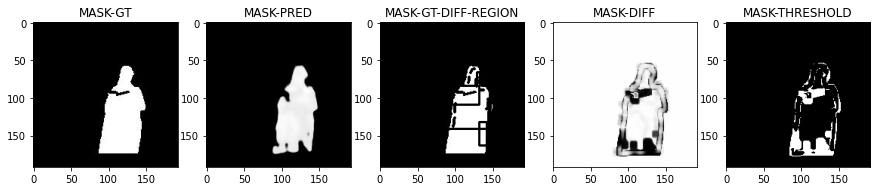

DEPTH Similarity Index: 0.343061745206288


<Figure size 432x288 with 0 Axes>

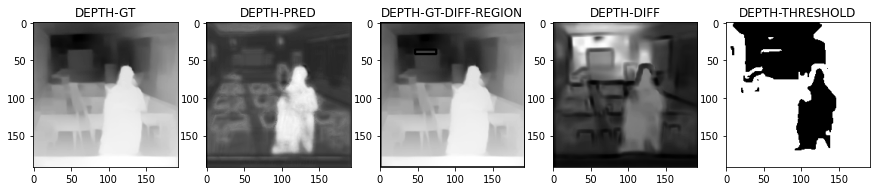

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

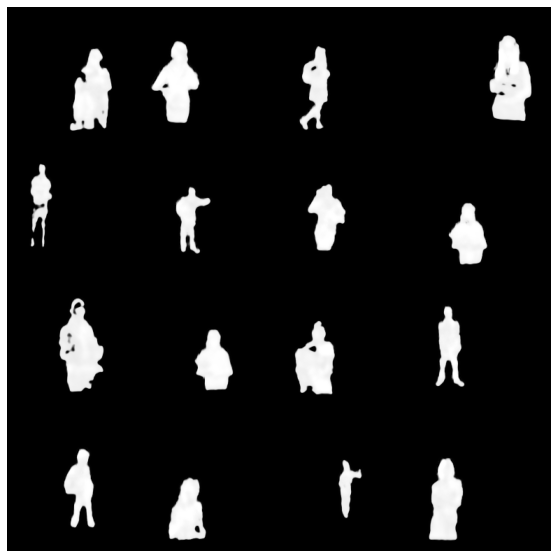

<Figure size 432x288 with 0 Axes>

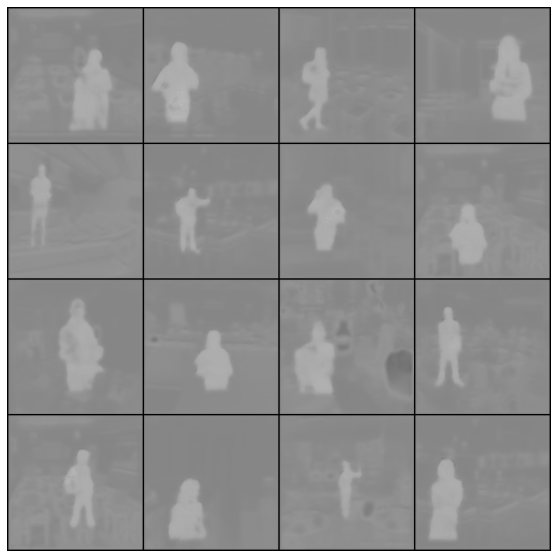

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Test Accuracy: mask_acc: 98.35%, depth_acc: 7.46%:  27%|██▋       | 999/3750 [07:31<20:17,  2.26it/s]


MASK Similarity Index: 0.929573663245825


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

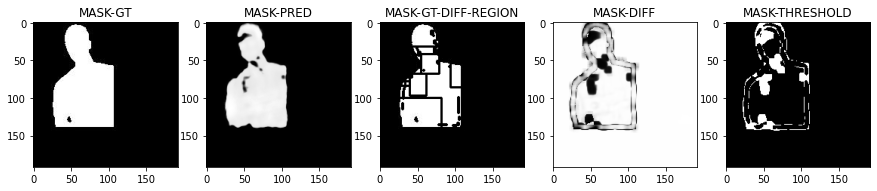

DEPTH Similarity Index: 0.2664424731093101


<Figure size 432x288 with 0 Axes>

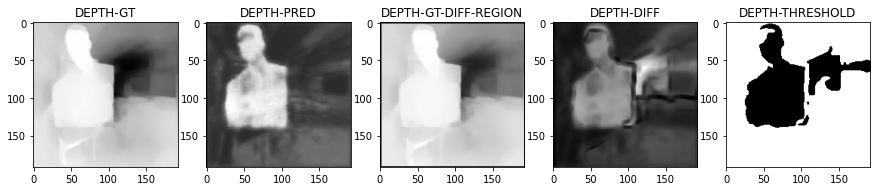

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

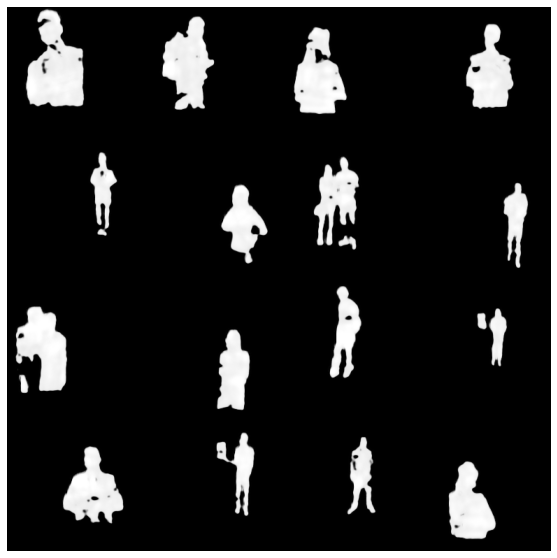

<Figure size 432x288 with 0 Axes>

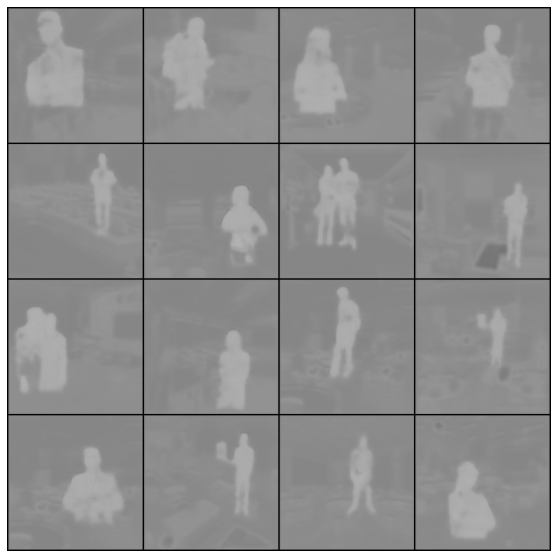

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Test Accuracy: mask_acc: 98.30%, depth_acc: 7.71%:  53%|█████▎    | 1999/3750 [15:00<12:49,  2.28it/s]


MASK Similarity Index: 0.9512542753806765


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

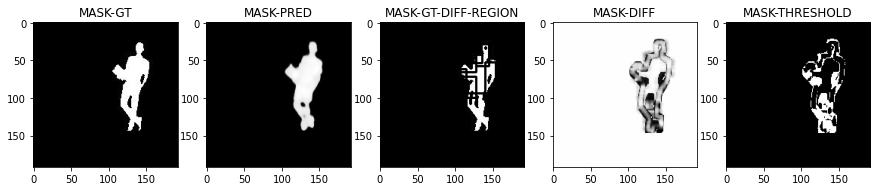

DEPTH Similarity Index: 0.3363296264771585


<Figure size 432x288 with 0 Axes>

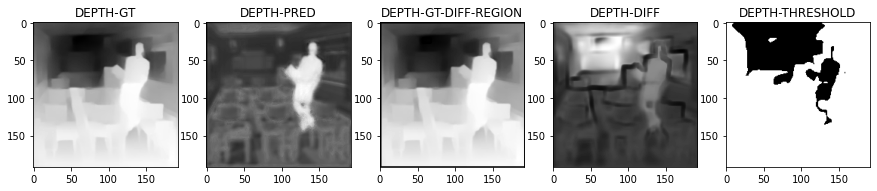

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

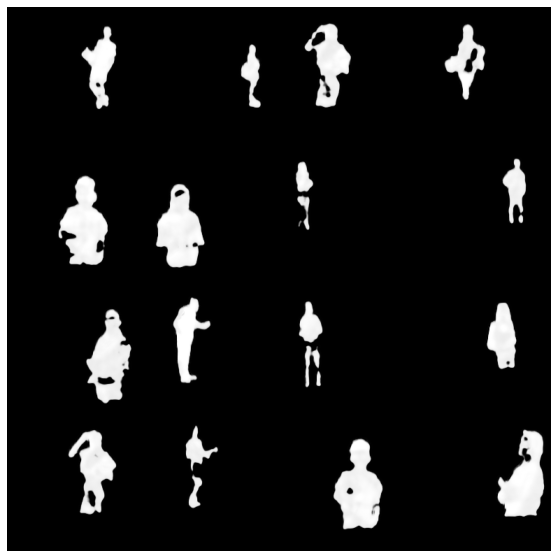

<Figure size 432x288 with 0 Axes>

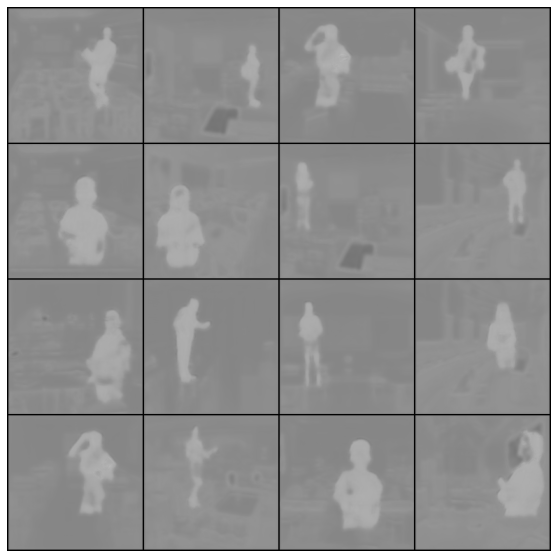

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Test Accuracy: mask_acc: 98.35%, depth_acc: 7.65%:  80%|███████▉  | 2999/3750 [22:27<05:29,  2.28it/s]


MASK Similarity Index: 0.9624212965270201


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

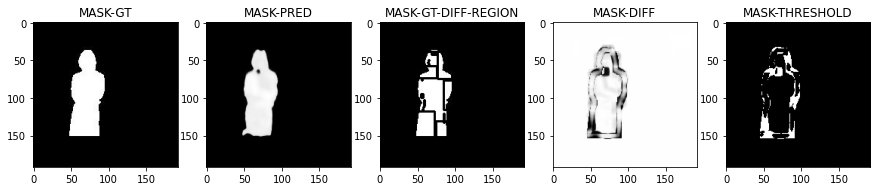

DEPTH Similarity Index: 0.39015279605587444


<Figure size 432x288 with 0 Axes>

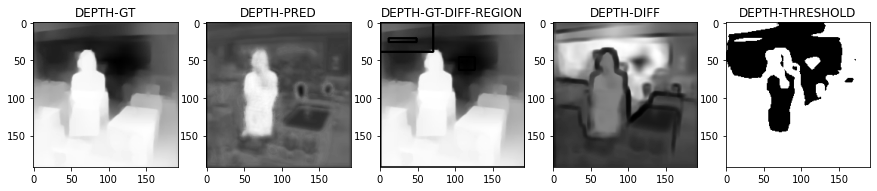

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<Figure size 432x288 with 0 Axes>

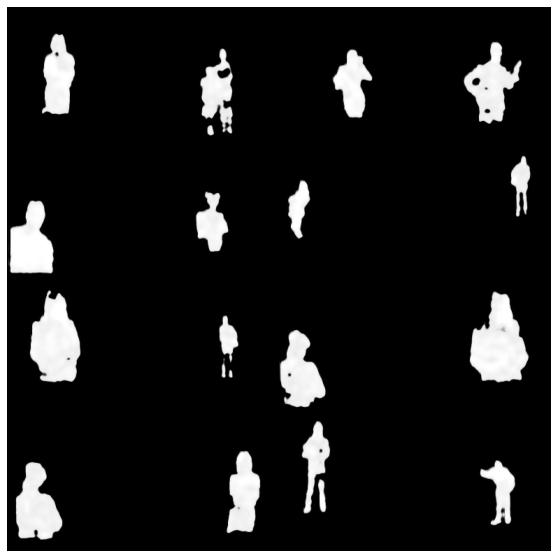

<Figure size 432x288 with 0 Axes>

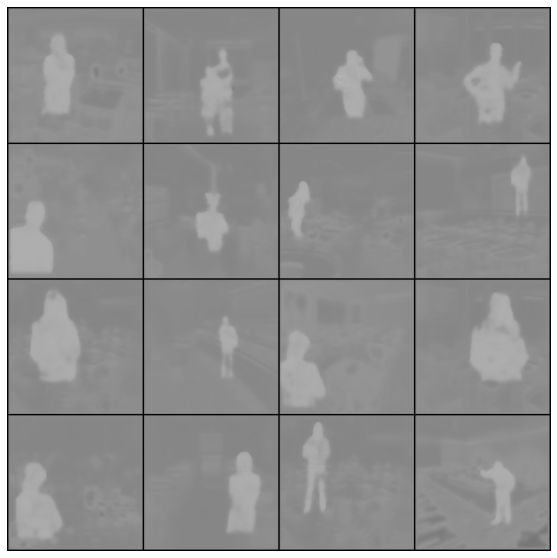

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Test Accuracy: mask_acc: 98.33%, depth_acc: 7.62%: 100%|██████████| 3750/3750 [28:03<00:00,  2.23it/s]


<Figure size 432x288 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [0]:
from  models.depthmap.DMNet_CNN import CNNDepthNet
import kornia

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/TR_CNN_SSIMLoss_ShortData')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

model_name = "DMNet_CNN"
model = CNNDepthNet().to(device)
MODEL_PATH = Path(f'./logs/logs_cnn_SSIMLoss_Shortdata/saved_models/model_ep30_testloss_0.130275980.pth')

model =  load_my_model(model, device, MODEL_PATH)

m_aac, d_acc = run_test_data(model, 
                            device, 
                            test_loader, 
                            ds_means_stds, 
                            path_dir=SAVED_RESULTS_DIR, 
                            m_threshold=m_threshold, 
                            d_threshold=d_threshold,
                            save_freq=save_freq)

In [0]:
print(f'Model: {model_name} - Trained on ShortData\nLoss: SSIMLoss\nMask Accuracy: {m_aac}%, Depth Accuracy: {d_acc}%')

Model: DMNet_CNN - Trained on ShortData
Loss: SSIMLoss
Mask Accuracy: 98.335%, Depth Accuracy: 7.618333333333333%


## Accuracy for Model build on entire 400K dataset [Trained on 280K smaples]

### Model-5: Test accuracy for model: Custom CNN 
- Model: DMNet_CNN_V1.py
- Dataset: Total 400K (Trained on 280K)
- Loss: BCEWithLogitsLoss

In [0]:
from  models.depthmap.DMNet_CNN_V1 import CNNDepthNet

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/TR_CNN_V1_BCEWithLogitsLoss_400k')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

model_name = "DMNet_CNN_V1"
model = CNNDepthNet().to(device)
MODEL_PATH = Path(f'./logs/logs_cnn_v1_BCEWithLogitsLoss_400k/saved_models/model_ep6_b1000_trainloss_0.938105114.pth')

model =  load_my_model(model, device, MODEL_PATH)

m_aac, d_acc = run_test_data(model, 
                            device, 
                            test_loader, 
                            ds_means_stds, 
                            path_dir=SAVED_RESULTS_DIR, 
                            m_threshold=m_threshold, 
                            d_threshold=d_threshold,
                            save_freq=save_freq)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(f'Model: {model_name}- Trained on 280K Dataset\nLoss: BCELogitsLoss\nMask Accuracy: {m_aac}%, Depth Accuracy: {d_acc}%')

Model: DMNet_CNN_V1- Trained on 280K Dataset
Loss: BCELogitsLoss
Mask Accuracy: 74.2525%, Depth Accuracy: 29.183333333333334%


### Model-6: Test accuracy for model:  Resnet 
- Model: ResnetDepthNet.py
- Dataset: Total 400K (Trained on 280K)
- Loss: BCEWithLogitsLoss

In [0]:
from  models.depthmap.DMNet_Resnet import ResnetDepthNet

SAVED_RESULTS_DIR = Path(f'./{SOLUTION_LOG_DIR}/TR_RESNET_BCEWithLogitsLoss_400k')
SAVED_RESULTS_DIR.mkdir(exist_ok=True)

model_name = "DMNet_Resnet"
model = ResnetDepthNet().to(device)
MODEL_PATH = Path(f'./logs/logs_resnet_BCELogitsLoss_400k_Part2/saved_models/model_ep19_b8000_trainloss_0.898744365.pth')


model =  load_my_model(model, device, MODEL_PATH)

m_aac, d_acc = run_test_data(model, 
                            device, 
                            test_loader, 
                            ds_means_stds, 
                            path_dir=SAVED_RESULTS_DIR, 
                            m_threshold=m_threshold, 
                            d_threshold=d_threshold,
                            save_freq=save_freq)

Output hidden; open in https://colab.research.google.com to view.

In [0]:
print(f'Model: {model_name}- Trained on 280K Dataset\nLoss: BCELogitsLoss\nMask Accuracy: {m_aac}%, Depth Accuracy: {d_acc}%')

Model: DMNet_Resnet- Trained on 280K Dataset
Loss: BCELogitsLoss
Mask Accuracy: 83.65583333333333%, Depth Accuracy: 51.99166666666667%


### Tensor board

In [0]:
tb_writer.close()

In [0]:
print(TENSOR_BOARD_LOG_DIR)

In [0]:
%tensorboard --logdir ./logs/logs_accuracy/tb_logs